🔥 GPU Detected: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}
✅ Dataset path detected: /root/.cache/kagglehub/datasets/atreyamajumdar/mstar-dataset-8-classes/versions/1/Padded_imgs
✅ Found 8 classes: ['2S1', 'BRDM_2', 'BTR_60', 'D7', 'SLICY', 'T62', 'ZIL131', 'ZSU_23_4']
✅ Dataset Loaded: (9466, 128, 128, 3), Labels: (9466,)
✅ Data Generators Ready!
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


474/474 ━━━━━━━━━━━━━━━━━━━━ 140s 160ms/step - accuracy: 0.6272 - loss: 1.1011 - val_accuracy: 0.2249 - val_loss: 6.3714
Epoch 2/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 39s 82ms/step - accuracy: 0.8886 - loss: 0.3421 - val_accuracy: 0.1362 - val_loss: 6.4789
Epoch 3/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 37s 79ms/step - accuracy: 0.9309 - loss: 0.2129 - val_accuracy: 0.2186 - val_loss: 8.3317
Epoch 4/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - accuracy: 0.9072 - loss: 0.2822 - val_accuracy: 0.4931 - val_loss: 5.1456
Epoch 5/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - accuracy: 0.9534 - loss: 0.1322 - val_accuracy: 0.3844 - val_loss: 5.7832
Epoch 6/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - accuracy: 0.9658 - loss: 0.1155 - val_accuracy: 0.5216 - val_loss: 3.9723
Epoch 7/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.9340 - loss: 0.2058 - val_accuracy: 0.6526 - val_loss: 2.0554
Epoch 8/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.9591 - loss: 0.1261 - val_accur

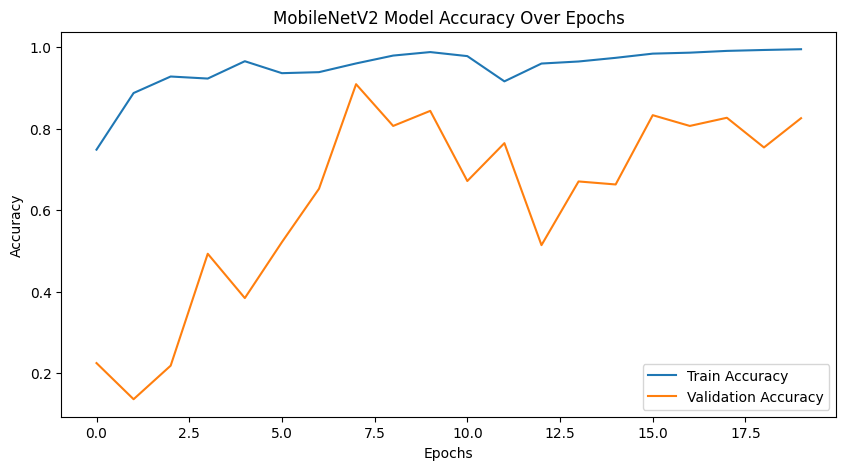

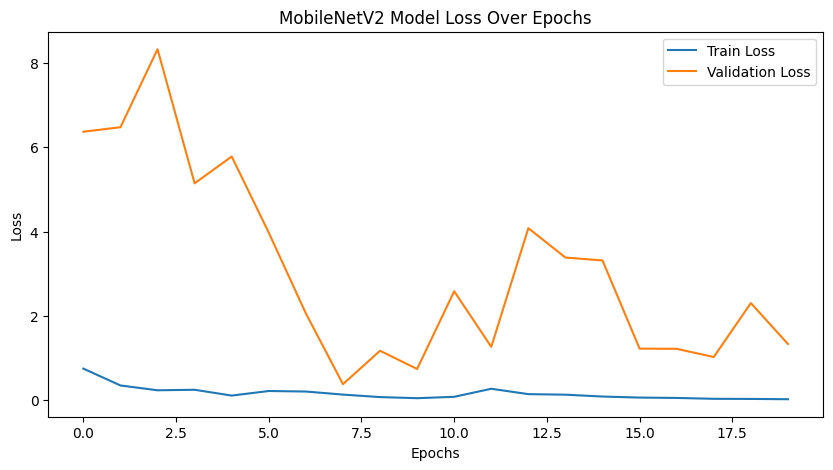

In [ ]:
# ✅ Import Necessary Libraries
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import kagglehub
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# ✅ Enable Mixed Precision for Faster Training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# ✅ Enable GPU Memory Growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"🔥 GPU Detected: {tf.config.experimental.get_device_details(physical_devices[0])}")
else:
    print("❌ No GPU detected, running on CPU.")

# ✅ Download Dataset Dynamically
dataset_path = kagglehub.dataset_download("atreyamajumdar/mstar-dataset-8-classes")

# ✅ Detect Correct Dataset Path
if "versions" in dataset_path:
    DATASET_PATH = os.path.join(dataset_path, "Padded_imgs")
else:
    DATASET_PATH = os.path.join(dataset_path, "versions", "1", "Padded_imgs")

# ✅ Verify Dataset Path
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"❌ Dataset path does not exist: {DATASET_PATH}")

print(f"✅ Dataset path detected: {DATASET_PATH}")

# ✅ Get Class Names
classes = sorted(os.listdir(DATASET_PATH))
num_classes = len(classes)
print(f"✅ Found {num_classes} classes: {classes}")

# ✅ Define Image Size
IMG_SIZE = (128, 128)

# ✅ Load Images & Labels
X, y = [], []
for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(DATASET_PATH, class_name)
    image_paths = glob.glob(class_path + "/*.JPG")

    if not image_paths:
        print(f"⚠️ Warning: No images found in {class_path}")
        continue

    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        X.append(img)
        y.append(class_idx)

# ✅ Convert to NumPy Arrays
X = np.array(X, dtype=np.float32) / 255.0  # Normalize
y = np.array(y)
print(f"✅ Dataset Loaded: {X.shape}, Labels: {y.shape}")

# ✅ Train-Validation-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ✅ One-Hot Encode Labels
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# ✅ Apply Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=16)
val_generator = val_datagen.flow(X_val, y_val_cat, batch_size=16)
test_generator = test_datagen.flow(X_test, y_test_cat, batch_size=16, shuffle=False)

print("✅ Data Generators Ready!")

# ✅ Load Pretrained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# ✅ Unfreeze Last 10 Layers for Fine-Tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# ✅ Add Custom Classification Layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(num_classes, activation='softmax')(x)

# ✅ Create MobileNetV2 Model
mobilenet_model = Model(inputs=base_model.input, outputs=out)

# ✅ Apply Learning Rate Scheduling (Cosine Decay)
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=0.0005,
    first_decay_steps=10,
    t_mul=2.0,
    alpha=0.0001
)

# ✅ Compile Model for GPU Training
mobilenet_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Train MobileNetV2 with GPU & Fine-Tuning
with tf.device('/GPU:0'):
    history_mobilenet = mobilenet_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        batch_size=16
    )

# ✅ Evaluate Fine-Tuned MobileNetV2 Model
loss, accuracy = mobilenet_model.evaluate(test_generator)
print(f"✅ Fine-Tuned MobileNetV2 Model Accuracy: {accuracy:.4f}")

# ✅ Save Fine-Tuned Model
mobilenet_model.save("/content/mstar_mobilenetv2_finetuned.keras")
print("🎯 Fine-tuned MobileNetV2 training completed and saved successfully!")

# ✅ Plot Training Curves
plt.figure(figsize=(10,5))
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('MobileNetV2 Model Accuracy Over Epochs')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('MobileNetV2 Model Loss Over Epochs')
plt.show()


In [ ]:
# ✅ Import Necessary Libraries
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import kagglehub
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2  # ✅ Reduced Regularization
from sklearn.model_selection import train_test_split

# ✅ Enable Mixed Precision for Faster Training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# ✅ Enable GPU Memory Growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"🔥 GPU Detected: {tf.config.experimental.get_device_details(physical_devices[0])}")
else:
    print("❌ No GPU detected, running on CPU.")

# ✅ Download Dataset Dynamically
dataset_path = kagglehub.dataset_download("atreyamajumdar/mstar-dataset-8-classes")

# ✅ Detect Correct Dataset Path
if "versions" in dataset_path:
    DATASET_PATH = os.path.join(dataset_path, "Padded_imgs")
else:
    DATASET_PATH = os.path.join(dataset_path, "versions", "1", "Padded_imgs")

# ✅ Verify Dataset Path
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"❌ Dataset path does not exist: {DATASET_PATH}")

print(f"✅ Dataset path detected: {DATASET_PATH}")

# ✅ Get Class Names
classes = sorted(os.listdir(DATASET_PATH))
num_classes = len(classes)
print(f"✅ Found {num_classes} classes: {classes}")

# ✅ Define Image Size
IMG_SIZE = (128, 128)

# ✅ Load Images & Labels
X, y = [], []
for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(DATASET_PATH, class_name)
    image_paths = glob.glob(class_path + "/*.JPG")

    if not image_paths:
        print(f"⚠️ Warning: No images found in {class_path}")
        continue

    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        X.append(img)
        y.append(class_idx)

# ✅ Convert to NumPy Arrays
X = np.array(X, dtype=np.float32) / 255.0  # Normalize
y = np.array(y)
print(f"✅ Dataset Loaded: {X.shape}, Labels: {y.shape}")

# ✅ Train-Validation-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ✅ One-Hot Encode Labels
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# ✅ Apply Data Augmentation (Enhanced)
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,  # ✅ Added Shear Transform
    brightness_range=[0.8, 1.2],  # ✅ Adjust Brightness
    channel_shift_range=0.1  # ✅ Contrast Adjustment
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=16)
val_generator = val_datagen.flow(X_val, y_val_cat, batch_size=16)
test_generator = test_datagen.flow(X_test, y_test_cat, batch_size=16, shuffle=False)

print("✅ Data Generators Ready!")

# ✅ Load Pretrained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# ✅ Unfreeze Only Last 5 Layers for Fine-Tuning
for layer in base_model.layers[:-5]:
    layer.trainable = False

# ✅ Add Custom Classification Layers with L2 Regularization
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.0001))(x)  # ✅ Lowered L2 Regularization
x = Dropout(0.4)(x)  # ✅ Increased Dropout from 0.3 → 0.4
out = Dense(num_classes, activation='softmax')(x)

# ✅ Create MobileNetV2 Model
mobilenet_model = Model(inputs=base_model.input, outputs=out)

# ✅ Use Exponential Decay for Learning Rate (Lower Initial LR)
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,  # ✅ Lowered LR from 0.0005 → 0.0001
    decay_steps=30000,
    decay_rate=0.95,
    staircase=True
)

# ✅ Compile Model with Reduced Label Smoothing
mobilenet_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),  # ✅ Reduced Label Smoothing
    metrics=['accuracy']
)

# ✅ Train MobileNetV2 with GPU & Fine-Tuning
with tf.device('/GPU:0'):
    history_mobilenet = mobilenet_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        batch_size=16
    )

# ✅ Evaluate Fine-Tuned MobileNetV2 Model
loss, accuracy = mobilenet_model.evaluate(test_generator)
print(f"✅ Fine-Tuned MobileNetV2 Model Accuracy: {accuracy:.4f}")

# ✅ Save Fine-Tuned Model
mobilenet_model.save("/content/mstar_mobilenetv2_finetuned.keras")
print("🎯 Fine-tuned MobileNetV2 training completed and saved successfully!")

# ✅ Plot Training Curves
plt.figure(figsize=(10,5))
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('MobileNetV2 Model Accuracy Over Epochs')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('MobileNetV2 Model Loss Over Epochs')
plt.show()
